### DCT3SNN - DCT-2 Encoded Dataset

The dataset is encoded using the recursive radix-2 DCT-II algorithm. The encodings are real valued. </br>
Results demonstrate perfect reconstruction of the original codeword

In [1]:
# (r + 1) | (q - 1)
# (r + 1) | n
# q is a prime number
# n = 2^t
# r < n

In [2]:
%reset -f
import gc
gc.collect()

0

In [3]:
import numpy as np

np.random.seed(42)

n = 16
q = 5
num_samples = 1000

def next_power_of_two(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

n_padded = next_power_of_two(n)

dataset = np.random.randint(0, q, size=(num_samples, n))

if n_padded > n:
    pad_width = n_padded - n
    dataset = np.pad(dataset, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

print("Original n:", n)
print("Padded n:", n_padded)
print("Generated dataset shape:", dataset.shape)

Original n: 16
Padded n: 16
Generated dataset shape: (1000, 16)


In [4]:
print(dataset)
print(dataset.shape)
print(dataset[0].shape)

[[3 4 2 ... 1 3 1]
 [3 4 0 ... 3 2 3]
 [3 0 2 ... 0 1 4]
 ...
 [4 4 4 ... 0 2 2]
 [4 2 4 ... 4 0 0]
 [2 2 2 ... 0 4 2]]
(1000, 16)
(16,)


In [5]:
def cos2(x, n):
    if n == 2:
        H_2 = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
        return H_2 @ x
    else:
        n1 = n // 2
        
        I_half = np.eye(n1)
        I_tilde_half = np.flip(I_half, axis=1)
        H = np.block([
            [I_half, I_tilde_half], 
            [I_half, -I_tilde_half]
        ])
        H_n = (1 / np.sqrt(2)) * H
        u = H_n @ x
        
        W_entries = [1] * n1 + [ (1 / np.cos((2*k - 1)*np.pi / (2*n))) / 2 for k in range(1, n1+1) ]
        W_c = np.diag(W_entries)
        v = W_c @ u
        
        z1 = cos2(v[:n1], n1)
        z2 = cos2(v[n1:], n1)
        
        B = np.eye(n1)
        np.fill_diagonal(B[:-1, 1:], 1)
        B[0, 0] = np.sqrt(2)
        B_c = np.block([
            [np.eye(n1), np.zeros((n1, n1))], 
            [np.zeros((n1, n1)), B]
        ])
        w = B_c @ np.concatenate([z1, z2])
        
        perm = np.arange(n).reshape(2, -1).T.flatten()
        y = w[perm]

        return y

In [6]:
encoded_dataset = np.array([cos2(message, n_padded) for message in dataset])
encoded_dataset[np.abs(encoded_dataset) < 1e-10] = 0
encoded_dataset = np.round(encoded_dataset, decimals=10)
print(encoded_dataset)

[[10.5         1.26383132  0.23549485 ...  0.99641577 -1.18391256
   0.62689581]
 [ 8.5         0.1771992   2.06115683 ... -1.75713705 -2.05152122
  -0.99053701]
 [ 7.25        1.0749807   0.49007978 ... -0.53638835 -2.15286363
   0.39362506]
 ...
 [ 9.25        4.32802462  1.51024903 ...  0.43115947 -1.18524598
   0.36995936]
 [10.          0.58621259 -1.25590356 ...  1.41169444  1.93868323
  -0.37231064]
 [ 8.75       -0.52259211 -0.66741344 ...  0.07678143  2.07385623
   1.58517901]]


In [7]:
encoded_dataset.shape

(1000, 16)

In [8]:
print(dataset[0])
print(encoded_dataset[0])

[3 4 2 4 4 1 2 2 2 4 3 2 4 1 3 1]
[10.5         1.26383132  0.23549485  1.56229549 -1.1480503  -0.97258159
 -0.11506236  1.16365963  0.5         0.30816899  0.172203   -1.08679973
 -2.7716386   0.99641577 -1.18391256  0.62689581]


In [9]:
# normalize target data
y_normalized = dataset.astype(np.float32) / (q - 1)  # Scale to [0, 1]
print(y_normalized[0])

[0.75 1.   0.5  1.   1.   0.25 0.5  0.5  0.5  1.   0.75 0.5  1.   0.25
 0.75 0.25]


In [10]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    encoded_dataset, y_normalized, test_size=0.2, random_state=42
)
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (800, 16) (800, 16)
Testing data shape: (200, 16) (200, 16)


In [11]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
print(input_dim)
print(output_dim)

16
16


DCT-3 Structure Imposed Neural Network

In [12]:
import tensorflow as tf

In [13]:
class FirstLayer(tf.keras.layers.Layer):
  def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
    super(FirstLayer, self).__init__(**kwargs)
    self.units = units # features/neurons
    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer
    self.use_bias = use_bias

  def build(self, input_shape):
    # input_shape --> (batch_size, input_dim)
    n = self.units
    n1 = n // 2
    
    self.d_1 = self.add_weight(name ="kernel_d1",
                               shape=(n1,),
                               initializer=tf.keras.initializers.get(self.kernel_initializer),
                              #  regularizer=tf.keras.regularizers.l2(1e-4),
                               trainable=True)
    self.d_2 = self.add_weight(name ="kernel_d2",
                               shape=(n1,),
                               initializer=tf.keras.initializers.get(self.kernel_initializer),
                              #  regularizer=tf.keras.regularizers.l2(1e-4),
                               trainable=True)
    if self.use_bias:
      self.bias = self.add_weight(name ="bias",
                                  shape=(self.units,),
                                  initializer=tf.keras.initializers.get(self.bias_initializer),
                                  # regularizer=tf.keras.regularizers.l2(1e-4),
                                  trainable=True)

  def call(self, inputs):
    # print("Enters first layer")
    P_n = tf.concat([inputs[:, ::2], inputs[:, 1::2]], axis=1) # permutation [x0, x2, x4, ..., xn-2, x1, x3, x5, ..., xn-1]
    out1 = P_n[:, :int(P_n.shape[1]/2)] # even indices [x0 x2 x4 ...]
    out2 = P_n[:, int(P_n.shape[1]/2):] # odd indices [x1 x3 x5 ...]
    
    # expected output for rearrange out2 after bidiagonal matrix ---> out2_n = [sqrt(2).x1, x1+x3, x3+x5+ ..., xn-3+xn-1]   
    
    out3 = tf.add(
      tf.multiply(out2, self.d_1), # diagonal
      tf.multiply(tf.concat([tf.zeros_like(out2[:, :1]), out2[:, :-1]], axis=1), self.d_2) # super diagonal
    )
    
    out = tf.concat([out1, out3], axis=1) # [x0 x2 x4 ... sqrt(2).x1, x1+x3, x3+x5+ ..., xn-3+xn-1]

    if self.use_bias:
      out += self.bias

    return out

In [14]:
class SecondLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(SecondLayer, self).__init__(**kwargs)
        self.units = units  # Number of neurons/features
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        n1 = n // 2
        num_blocks = n1 // 2  # Number of 2×2 blocks needed for c1 and c2 (for 16 we need 4 blocks)

        self.d_1 = self.add_weight(name="kernel_d1",
                                   shape=(n1 - 2,),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)
        self.d_2 = self.add_weight(name="kernel_d2",
                                   shape=(n1 - 2,),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)
        self.w = self.add_weight(name="kernel_w",
                                 shape=(n1 - 2,),
                                 initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #  regularizer=tf.keras.regularizers.l2(1e-5),
                                 trainable=True)
    
        self.C_1 = self.add_weight(name="kernel_C_1",
                                   shape=(num_blocks, 2, 2),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)
        self.C_2 = self.add_weight(name="kernel_C_2",
                                   shape=(num_blocks, 2, 2),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        # regularizer=tf.keras.regularizers.l2(1e-4),
                                        trainable=True)
    
    def call(self, inputs):
        # print("Enters second layer")
        
        def build_final_matrix(C, n1):
            """Constructs an n1 x n1 block-diagonal matrix from 2x2 blocks in C."""
            final_C = tf.eye(n1)  # initialize as an identity matrix
            num_blocks = n1 // 2

            for i in range(num_blocks):
                final_C = tf.tensor_scatter_nd_update(
                    final_C,
                    indices=[[2*i, 2*i], [2*i, 2*i+1], [2*i+1, 2*i], [2*i+1, 2*i+1]],
                    updates=tf.reshape(C[i], (-1,))
                )

            return final_C

        def recursiveDCTIII(inputVector, d_1, d_2, w, C, level):
            n = inputVector.shape[1]

            if n == 2:
                out = tf.matmul(inputVector, C[level])  # select correct 2×2 matrix
                return out
            else:
                P_n = tf.concat([inputVector[:, ::2], inputVector[:, 1::2]], axis=1)  # Permutation
                out1 = P_n[:, :n // 2]
                out2 = P_n[:, n // 2:]

                # Apply diagonal and superdiagonal scaling
                d1 = tf.multiply(out2, tf.reshape(d_1[:(n // 2)], (1, -1)))
                d2 = tf.concat([tf.zeros_like(out2[:, :1]), tf.multiply(out2[:, :-1], tf.reshape(d_2[:(n // 2) - 1], (1, -1)))], axis=1)
                out2_bn = tf.add(d1, d2)

                # Recursively apply DCT-III
                out1_n = recursiveDCTIII(out1, d_1[n // 2:], d_2[n // 2:], w[n // 2:], C, level + 1)
                out2_n = recursiveDCTIII(out2_bn, d_1[n // 2:], d_2[n // 2:], w[n // 2:], C, level + 1)

                out2_wn = tf.multiply(out2_n, tf.reshape(w[:n // 2], (1, -1)))

                out = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat(
                    [(out1_n + out2_wn), tf.reverse((out1_n - out2_wn), axis=[1])], axis=1)

                return out

        input1 = inputs[:, :self.units // 2]
        input2 = inputs[:, self.units // 2:]

        z1 = recursiveDCTIII(input1, self.d_1, self.d_2, self.w, self.C_1, level=0)
        z2 = recursiveDCTIII(input2, self.d_1, self.d_2, self.w, self.C_2, level=0)
        
        final_C1 = build_final_matrix(self.C_1, self.units // 2)
        final_C2 = build_final_matrix(self.C_2, self.units // 2)

        z1 = tf.matmul(z1, final_C1)
        z2 = tf.matmul(z2, final_C2)

        out = tf.concat([z1, z2], axis=1)

        if self.use_bias:
            out += self.bias

        return out


In [15]:
class ThirdLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(ThirdLayer, self).__init__(**kwargs)
        self.units = units # features/neurons
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        n1 = n // 2
        
        self.w = self.add_weight(name ="kernel_w",
                                      shape=(n1,),
                                      initializer=tf.keras.initializers.get(self.kernel_initializer),
                                    #   regularizer=tf.keras.regularizers.l2(1e-4),
                                      trainable=True)
        # self.h = self.add_weight(name ="kernel_h",
        #                               shape = (2,2),
        #                               initializer='glorot_normal',
        #                               trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name ="bias",
                                       shape=(self.units,),
                                       initializer=tf.keras.initializers.get(self.bias_initializer),
                                    #    regularizer=tf.keras.regularizers.l2(1e-4),
                                       trainable=True)

    def call(self, inputs):
        # print("Enters third layer")
        
        out1 = inputs[:, :int(inputs.shape[1] / 2)]
        out2 = inputs[:, int(inputs.shape[1] / 2):]

        # out1 - stays as is
        out3 = tf.multiply(out2, self.w)
        
        # TODO: make H trainable instead of hardcoded
        
        out = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat([(out1 + out3), tf.reverse((out1 - out3), axis=[1])], axis=1)
        
        if self.use_bias:
            out += self.bias

        return out

In [16]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.units = units # features/neurons
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        
        self.m = self.add_weight(name ="kernel_m",
                                      shape=(n,),
                                      initializer=tf.keras.initializers.get(self.kernel_initializer),
                                    #   regularizer=tf.keras.regularizers.l2(1e-4),
                                      trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name ="bias",
                                       shape=(self.units,),
                                       initializer=tf.keras.initializers.get(self.bias_initializer),
                                    #    regularizer=tf.keras.regularizers.l2(1e-4),
                                       trainable=True)

    def call(self, inputs):
        # print("Enters custom layer")

        out = tf.multiply(inputs, self.m)
        
        if self.use_bias:
            out += self.bias

        return out

only difference between the gen matrix encoded and dct encoded is the linear mapping (m weight matrix)

In [17]:
class LinearLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='ones', bias_initializer='zeros', use_bias=True, **kwargs):
        super(LinearLayer, self).__init__(**kwargs)
        self.units = units # features/neurons
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        
        self.m = self.add_weight(name ="kernel_m",
                                      shape=(n,),
                                      initializer=tf.keras.initializers.get(self.kernel_initializer),
                                      trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name ="bias",
                                       shape=(n,),
                                       initializer=tf.keras.initializers.get(self.bias_initializer),
                                       trainable=True)

    def call(self, inputs):
        # print("Enters last linear layer")
        # print("linear layer input shape:", inputs.shape)

        out = tf.multiply(inputs, self.m)
        
        if self.use_bias:
            out += self.bias
            
        # print("linear layer output shape:", out.shape)
        
        return out

Compile Model

In [18]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Concatenate, LeakyReLU, Activation

def cosine_loss(y_true, y_pred):
    y_true_norm = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=-1)

    return 1 - tf.reduce_mean(tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1))  # 1 - Cosine similarity


def hybrid_loss(y_true, y_pred):
    mse_part = tf.reduce_mean(tf.square(y_true - y_pred))  # MSE
    cos_part = cosine_loss(y_true, y_pred)
    return 0.5 * mse_part + 0.5 * cos_part


def structured_NN(input_dim, output_dim):
    model = tf.keras.Sequential([
        Input(shape=(input_dim,)),
        FirstLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="layer1"),
        LeakyReLU(alpha=0.1),
        CustomLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="support_layer_1"),
        LeakyReLU(alpha=0.1),
        SecondLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="layer2"),
        LeakyReLU(alpha=0.1),
        CustomLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="support_layer_2"),
        LeakyReLU(alpha=0.1),
        ThirdLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="layer3"),
        LeakyReLU(alpha=0.1),
        LinearLayer(units=output_dim, kernel_initializer='ones', bias_initializer='zeros', name="output_layer"),
        Activation('sigmoid') #sigmoid #linear #softmax 
        ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=hybrid_loss, #Huber(delta=0.5), #mean_squared_error',
        metrics=['mse', 'mae']
    )
    return model


input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = structured_NN(input_dim, output_dim)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (FirstLayer)         (None, 16)                32        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16)                0         
                                                                 
 support_layer_1 (CustomLay  (None, 16)                32        
 er)                                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16)                0         
                                                                 
 layer2 (SecondLayer)        (None, 16)                66        
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16)                0         
                                                       

In [19]:
for layer in model.layers:
    print(layer.name, layer.output_shape)

layer1 (None, 16)
leaky_re_lu (None, 16)
support_layer_1 (None, 16)
leaky_re_lu_1 (None, 16)
layer2 (None, 16)
leaky_re_lu_2 (None, 16)
support_layer_2 (None, 16)
leaky_re_lu_3 (None, 16)
layer3 (None, 16)
leaky_re_lu_4 (None, 16)
output_layer (None, 16)
activation (None, 16)


Training the NN

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [21]:
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[adjust_lr, early_stopping]
)

Epoch 1/500


25/25 [==============================] - 6s 55ms/step - loss: 0.1543 - mse: 0.1265 - mae: 0.3038 - val_loss: 0.1556 - val_mse: 0.1254 - val_mae: 0.3014 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 6ms/step - loss: 0.1542 - mse: 0.1265 - mae: 0.3040 - val_loss: 0.1555 - val_mse: 0.1254 - val_mae: 0.3015 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 6ms/step - loss: 0.1541 - mse: 0.1264 - mae: 0.3041 - val_loss: 0.1555 - val_mse: 0.1254 - val_mae: 0.3017 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 6ms/step - loss: 0.1540 - mse: 0.1263 - mae: 0.3042 - val_loss: 0.1554 - val_mse: 0.1253 - val_mae: 0.3018 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 6ms/step - loss: 0.1538 - mse: 0.1261 - mae: 0.3042 - val_loss: 0.1552 - val_mse: 0.1251 - val_mae: 0.3019 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 6ms/step - loss: 0.1535 - mse: 0.1259 - mae: 0.3042 - val_los

Evaluate

In [22]:
test_loss, test_mse, test_mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

7/7 [==============================] - 0s 3ms/step - loss: 0.0411 - mse: 0.0345 - mae: 0.1467
Test MSE: 0.0345, Test MAE: 0.1467


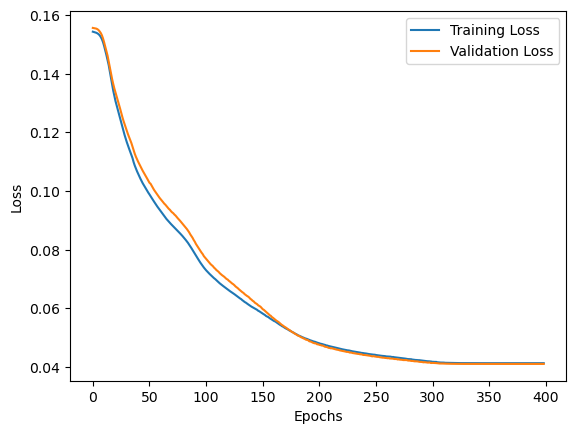

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
y_pred_test = model.predict(X_test)
y_pred_test_rescaled = y_pred_test * (q - 1)
y_test_rescaled = y_test * (q - 1)

print("Comparison of predictions and ground truth:")
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"  Predicted:    {np.round(y_pred_test_rescaled[i])}")
    print(f"  Ground Truth: {np.round(y_test_rescaled[i])}")
    print("-" * 40)


7/7 [==============================] - 1s 2ms/step
Comparison of predictions and ground truth:
Sample 1:
  Predicted:    [1. 1. 1. 1. 1. 2. 4. 1. 1. 3. 2. 2. 1. 2. 4. 2.]
  Ground Truth: [1. 0. 1. 1. 1. 1. 3. 0. 1. 3. 1. 2. 1. 1. 4. 2.]
----------------------------------------
Sample 2:
  Predicted:    [3. 0. 1. 1. 1. 2. 3. 2. 1. 2. 1. 2. 3. 1. 1. 1.]
  Ground Truth: [4. 0. 2. 0. 2. 0. 3. 2. 1. 2. 2. 2. 3. 0. 1. 0.]
----------------------------------------
Sample 3:
  Predicted:    [2. 1. 0. 0. 1. 1. 4. 3. 3. 3. 1. 2. 4. 2. 0. 1.]
  Ground Truth: [3. 2. 0. 0. 2. 0. 4. 4. 3. 3. 1. 3. 4. 3. 0. 1.]
----------------------------------------


In [25]:
def predict_on_unseen_data(model, q, num_samples=3):
    unseen_dataset = np.random.randint(0, q, size=(num_samples, n))
    
    padded_unseen_data = np.hstack((unseen_dataset, np.zeros((num_samples, n_padded - n))))

    encoded_unseen_dataset = np.array([cos2(message, n_padded) for message in padded_unseen_data])

    predictions = model.predict(encoded_unseen_dataset)

    predictions_rounded = np.round(predictions*q-1).astype(int)

    for i in range(num_samples):
        print(f"Sample {i+1}:")
        print(f"  Predicted:    {predictions_rounded[i]}")
        print(f"  Ground Truth: {unseen_dataset[i]}")
        print("-" * 40)

    return predictions_rounded, unseen_dataset

predictions, ground_truth = predict_on_unseen_data(model, q, num_samples=3)

1/1 [==============================] - 0s 30ms/step
Sample 1:
  Predicted:    [1 2 1 0 0 0 0 3 2 0 0 3 1 1 4 3]
  Ground Truth: [2 3 2 1 0 0 0 4 4 1 2 4 2 2 4 4]
----------------------------------------
Sample 2:
  Predicted:    [ 1  3  0  4  4  0  2  2  3  0  3  0 -1  2  2  0]
  Ground Truth: [1 3 0 4 4 2 3 4 3 0 2 1 0 3 3 0]
----------------------------------------
Sample 3:
  Predicted:    [3 0 0 4 2 0 2 3 2 3 2 3 2 1 1 0]
  Ground Truth: [3 1 1 3 3 1 3 4 2 4 3 3 2 3 2 1]
----------------------------------------


In [26]:
for layer in model.layers:
    if layer.trainable_variables:  # Check if the layer has trainable variables
        grads = tf.reduce_mean(tf.abs(layer.trainable_variables[0]))
        print(layer.name, "Gradient Mean:", grads.numpy())
    else:
        print(layer.name, "has no trainable variables.")

layer1 Gradient Mean: 0.6662954
leaky_re_lu has no trainable variables.
support_layer_1 Gradient Mean: 1.3332868
leaky_re_lu_1 has no trainable variables.
layer2 Gradient Mean: 1.3540019
leaky_re_lu_2 has no trainable variables.
support_layer_2 Gradient Mean: 1.3567832
leaky_re_lu_3 has no trainable variables.
layer3 Gradient Mean: 1.608211
leaky_re_lu_4 has no trainable variables.
output_layer Gradient Mean: 2.281895
activation has no trainable variables.
